# Introdução:

Análise de Dataset: Letras de Músicas

Este notebook compõe uma série de notebooks que tem como objetivo explorar e aplicar técnicas de NLP sobre o dataset `song_lyrics.csv`, conforme solicitado na prova prática para o CAEd.


# Configuração

In [ ]:
# Bibliotecas necessárias
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Tarefa (a)
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

# Baixando Dataset do Drive com gdown e extraindo zip
Link do Dataset: https://drive.google.com/file/d/13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c/view?usp=sharing

In [ ]:
# Baixar com gdown
!gdown 13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c

# Descompactar
with zipfile.ZipFile('dataset - letras.zip', 'r') as zip_ref:
    zip_ref.extractall('letras_dataset')

# Verificar arquivos
!ls letras_dataset

Downloading...
From (original): https://drive.google.com/uc?id=13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c
From (redirected): https://drive.google.com/uc?id=13T_SXgmSh9qGS2MJXZqQL6BQjfMs4S3c&confirm=t&uuid=28400186-a8ea-4658-a7a2-28a4a1e49364
To: /content/dataset - letras.zip
100% 3.26G/3.26G [00:39<00:00, 81.9MB/s]
song_lyrics.csv


# Leituras

Caso a `amostra_song_lyrics10.csv` já exista e esteja incluída no ambiente. Basta pular para a etapa de pré-processamento. A etapa já carrega a base de forma processada, evitando passos extras.

## Opção 1: Amostra criada anteriormente

In [ ]:
# Deve-se subir a amostra para o ambiente do colab. O nome do arquivo deve estar na variável path entre aspas
path = 'amostra_song_lyrics10.csv'
df = pd.read_csv(path)
df.head()

,title,tag,artist,year,views,features,lyrics,language
0,Ducky,rap,North Star (USA),2004,143,"{""Meko the Pharaoh"",Christbearer}","""Oh you'll love her"" (repeats all throughout)\...",en
1,The Heist Revisited,rap,Big L,2000,5204,{},"[Big L]\nYeah, yeah\nYeah-yeah, yeah-yeah-yeah...",en
2,Chinese New Year,rap,Clipse,2006,22502,"{""Roscoe P. Coldchain""}",[Chorus: Pusha T & Pharrell]\nI'm at your door...,en
3,Pop That Cannon,rap,Cassidy,2004,677,"{""Styles P"",""Swizz Beatz""}","[Intro - Swizz Beatz]\nAooow! banger, let's go...",en
4,Been This Way,rap,Scribe,2003,1014,{},[Intro]\nEvery MC in this industry wants one t...,en


## Opção 2: Lendo com chuncksize e criando amostra

In [ ]:
# Caminho do CSV
csv_path = 'letras_dataset/song_lyrics.csv'

# Colunas desejadas
usecols = ['title', 'tag', 'artist', 'year', 'views', 'features', 'lyrics', 'language']

# Parâmetros
chunksize = 50_000  # número de linhas por chunk
sample_frac = 0.1   # fração da amostra por chunk (10%)

# Lista para armazenar amostras
samples = []

# Leitura por chunks
for chunk in pd.read_csv(csv_path, usecols=usecols, chunksize=chunksize):
  sample = chunk.sample(frac=sample_frac, random_state=42)
  samples.append(sample)

# Concatenar todos os pedaços amostrados
df = pd.concat(samples).reset_index(drop=True)

# Visualizar forma e colunas
print(f"Total de linhas na amostra: {df.shape[0]}")
df.head()

# Salva a amostra reduzida
df.to_csv('amostra_song_lyrics10.csv', index=False)
print("Arquivo salvo como amostra_song_lyrics10.csv")

Total de linhas na amostra: 513486
Arquivo salvo como amostra_song_lyrics.csv


# Pré-processamento

## Remoção de Livros e Poemas

In [ ]:
# Configurações
path = 'amostra_song_lyrics10.csv'
chunksize = 10000
limite_palavras_livro = 2000

# Contadores
total_entradas = 0
removidos_livros = 0
removidos_poemas = 0
exemplos_livros = []
exemplos_poemas = []
entradas_mantidas = []

# Função para detectar poemas
def analisar_estrutura(letra):
  if not isinstance(letra, str) or not letra.strip():
    return False

  linhas = [linha.strip() for linha in letra.split('\n') if linha.strip()]
  if len(linhas) < 8:
    return False

  total_linhas = len(linhas)
  palavras = ' '.join(linhas).split()
  diversidade = len(set(palavras)) / len(palavras) if palavras else 0
  media_palavras = len(palavras) / total_linhas
  linhas_repetidas = total_linhas - len(set(linhas))
  proporcao_repetidas = linhas_repetidas / total_linhas
  linhas_curtas = [linha for linha in linhas if len(linha.split()) < 7]
  proporcao_curtas = len(linhas_curtas) / total_linhas

  # Filtros básicos
  if media_palavras < 4 or diversidade < 0.3:
      return False

  # Score poético
  score_poetico = proporcao_curtas * (1 - proporcao_repetidas)

  return score_poetico >= 0.6

# Leitura por partes
for chunk in pd.read_csv(path, usecols=['title', 'tag', 'artist', 'year', 'views', 'lyrics', 'language'], chunksize=chunksize):
  chunk.dropna(subset=['lyrics'], inplace=True)
  total_entradas += len(chunk)

  # Detectar livros
  chunk['len_lyrics'] = chunk['lyrics'].str.split().apply(len)
  filtro_livros = chunk['len_lyrics'] > limite_palavras_livro
  livros = chunk[filtro_livros]
  if len(exemplos_livros) < 2:
    exemplos_livros.extend(livros[['title', 'artist', 'len_lyrics', 'lyrics']].head(2).to_dict('records'))
  removidos_livros += len(livros)

  # Restante
  chunk = chunk[~filtro_livros]

  # Detectar poemas nas tags relevantes
  chunk.loc[:, 'tag'] = chunk['tag'].astype(str).str.lower()
  filtro_tag_poema = chunk['tag'].isin(['misc', 'other'])

  poemas_idx = []
  for idx, row in chunk[filtro_tag_poema].iterrows():
    if analisar_estrutura(row['lyrics']):
      poemas_idx.append(idx)
      if len(exemplos_poemas) < 2:
        exemplos_poemas.append({
          'title': row['title'],
          'artist': row['artist'],
          'score_poetico': '≈ estrutural',
          'lyrics': row['lyrics']
        })

  removidos_poemas += len(poemas_idx)
  chunk = chunk.drop(poemas_idx)

  # (opcional) salvar para uso posterior
  entradas_mantidas.append(chunk)

# Concatenar final se desejar
df = pd.concat(entradas_mantidas, ignore_index=True)

# Relatório
print("Relatório de Limpeza:")
print(f"Total de entradas analisadas: {total_entradas}")
print(f"Entradas removidas (livros): {removidos_livros}")
print(f"Entradas removidas (poemas): {removidos_poemas}")
print(f"Total removido: {removidos_livros + removidos_poemas}")
print(f"Total final mantido: {len(df)}")

print("\nExemplos removidos (livros):")
for e in exemplos_livros:
  print(f" - {e['title']} ({e['artist']}) | {e['len_lyrics']} palavras")
  print(f"Trecho:\n{e['lyrics'][:300]}\n")

print("\nExemplos removidos (poemas):")
for e in exemplos_poemas:
  print(f" - {e['title']} ({e['artist']})")
  print(f"Trecho:\n{e['lyrics'][:300]}\n")

Relatório de Limpeza:
Total de entradas analisadas: 513486
Entradas removidas (livros): 2488
Entradas removidas (poemas): 2960
Total removido: 5448
Total final mantido: 508038

Exemplos removidos (livros):
 - Paradise Lost Book 9 (John Milton) | 9030 palavras
Trecho:
No more of talk where God or Angel guest
With Man, as with his friend, familiar us'd
To sit indulgent, and with him partake
Rural repast; permitting him the while
Venial discourse unblam'd. I now must change
Those notes to tragick; distrust, and breach
Disloyal on the part of Man, revolt
And disobed

 - Rappers Delight (Sugarhill Gang) | 3195 palavras
Trecho:
[Chorus: Wonder Mike]
I said a hip-hop, the hippie, the hippie
To the hip, hip-hop and you don't stop the rockin'
To the bang-bang boogie, say up jump the boogie
To the rhythm of the boogie, the beat

[Verse 1: Wonder Mike]
Now, what you hear is not a test, I'm rapping to the beat
And me, the groove


Exemplos removidos (poemas):
 - The Tyger (William Blake)
Trecho:
T

## Limpeza no campo lyrics

In [ ]:
stop_words = set(stopwords.words('english'))

def clean_lyrics(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # remove URLs
  text = re.sub(r'\n+', ' ', text)
  text = re.sub(r'[^a-zA-Z ]', '', text)       # remove pontuação
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  # Remove letras únicas isoladas
  text = re.sub(r'\s+', ' ', text).strip()     # Remove espaços múltiplos e bordas

  tokens = text.split()
  tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
  return ' '.join(tokens)

df = df[df['language'] == 'en'].copy()
print(f"Total de letras em inglês: {df.shape[0]}")
df['lyrics'] = df['lyrics'].apply(clean_lyrics)
df.head()

Total de letras em inglês: 332731


,title,tag,artist,year,views,lyrics,language,len_lyrics
0,Ducky,rap,North Star (USA),2004,143,oh youll love repeats throughout intro christ ...,en,465
1,The Heist Revisited,rap,Big L,2000,5204,big yeah yeah yeahyeah yeahyeahyeahyeah yeah y...,en,696
2,Chinese New Year,rap,Clipse,2006,22502,chorus pusha pharrell im door eyes like judgin...,en,691
3,Pop That Cannon,rap,Cassidy,2004,677,intro swizz beatz aooow banger lets go swizz m...,en,562
4,Been This Way,rap,Scribe,2003,1014,intro every mc industry wants one thing best t...,en,785


# Tarefa (a): Análise de Polaridade

Objetivo: determinar polaridade das músicas ao longo do tempo

In [ ]:
# Criando o objeto de análise de sentimentos
analyzer = SentimentIntensityAnalyzer()

# Aplica em VADER em cada letra
def get_vader_polarity(text):
  scores = analyzer.polarity_scores(text)
  return pd.Series({
    'compound': scores['compound'],
    'pos': scores['pos'],
    'neu': scores['neu'],
    'neg': scores['neg']
  })

# Aplicar ao dataset
df[['tb_polarity', 'pos', 'neu', 'neg']] = df['lyrics'].apply(get_vader_polarity)

# Categorizar polaridade
def polaridade_label(score):
  if score >= 0.05:
    return 'positive'
  elif score <= -0.05:
    return 'negative'
  else:
    return 'neutral'

df['tb_sentiment'] = df['tb_polarity'].apply(polaridade_label)

df[['title', 'artist', 'year', 'tb_polarity', 'tb_sentiment']].sample(5)

,title,artist,year,tb_polarity,tb_sentiment
176334,Savior,The Fall of Troy,2016,-0.9519,negative
458820,Torino English Translation,Hamza,2021,0.9948,positive
108103,Beautiful In My Eyes,Christian Bautista,2015,0.9964,positive
86484,Every Little Thing,Hawk Nelson,2004,0.9058,positive
111603,Most Unpleasant Man,Eels,2015,-0.7351,negative


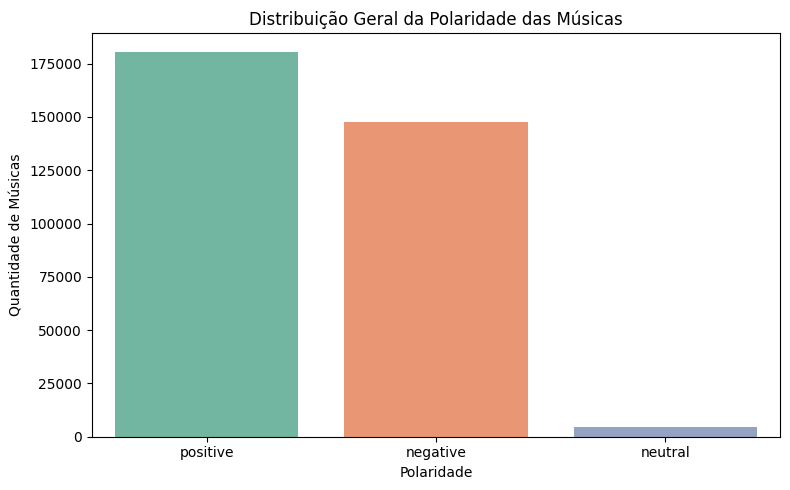

In [ ]:
# Distribuição da polaridade geral
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='tb_sentiment', palette='Set2', hue='tb_sentiment')
plt.title("Distribuição Geral da Polaridade das Músicas")
plt.xlabel("Polaridade")
plt.ylabel("Quantidade de Músicas")
plt.tight_layout()
plt.show()

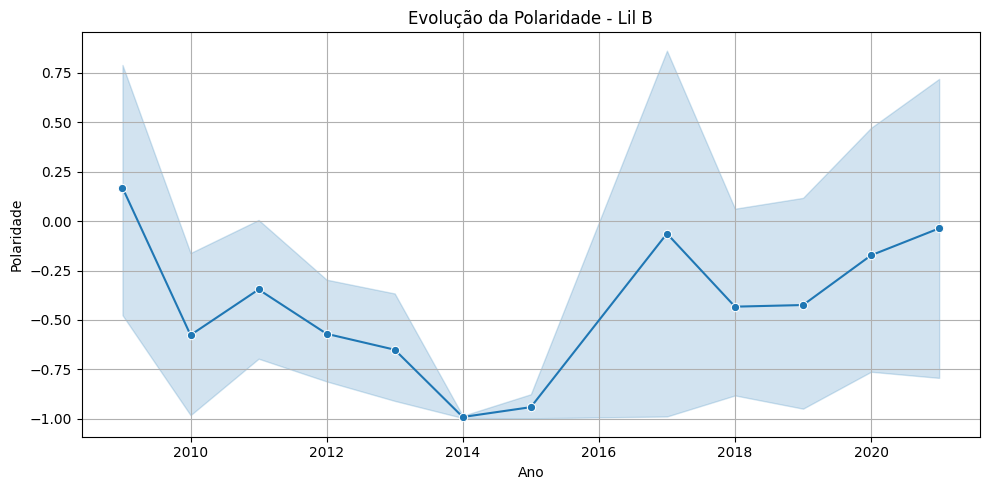

In [ ]:
# Analisar polaridade ao longo do tempo de um artista
# Escolher algum artista com muitas músicas
top_artistas = df['artist'].value_counts()
artista_exemplo = top_artistas.index[2]

# Filtrar esse artista
df_artista = df[df['artist'] == artista_exemplo]

plt.figure(figsize=(10,5))
sns.lineplot(data=df_artista.sort_values('year'), x='year', y='tb_polarity', marker='o')
plt.title(f"Evolução da Polaridade - {artista_exemplo}")
plt.ylabel("Polaridade")
plt.xlabel("Ano")
plt.grid(True)
plt.tight_layout()
plt.show()

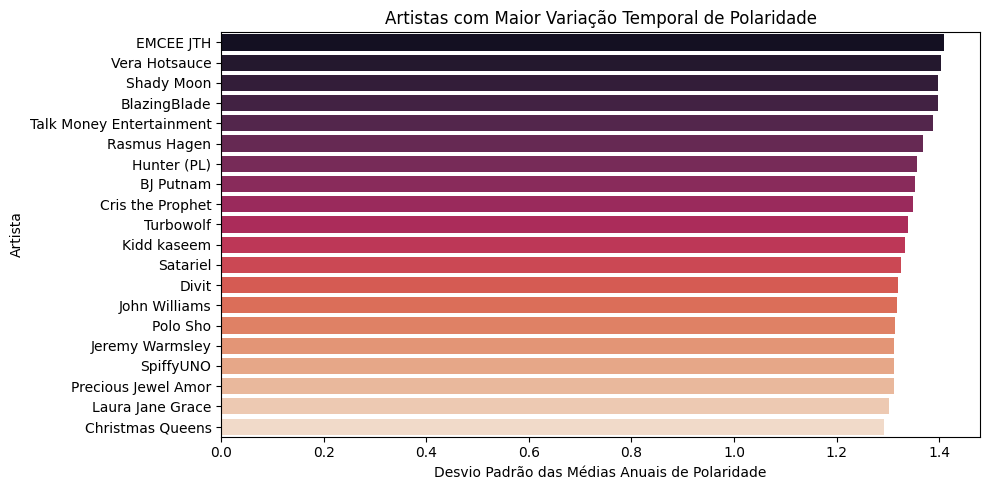

In [ ]:
# Identificar artistas com maior variação de polaridade ao longo do tempo

# Filtra artistas com ao menos 5 músicas
grupo = df.groupby('artist').filter(lambda x: len(x) >= 5)

# Remove NaN e garante polaridade válida
grupo = grupo[(grupo['tb_polarity'].notna()) & (grupo['tb_polarity'].between(-1, 1))]

# Agrupa por artista e ano, e tira média da polaridade
polaridade_por_ano = grupo.groupby(['artist', 'year'])['tb_polarity'].mean().reset_index()

# Desvio padrão da polaridade ao longo do tempo
variacao_temporal = polaridade_por_ano.groupby('artist')['tb_polarity'].std().sort_values(ascending=False)
top_temporais = variacao_temporal.head(20)

plt.figure(figsize=(10,5))
sns.barplot(x=top_temporais.values, y=top_temporais.index, palette='rocket')
plt.title("Artistas com Maior Variação Temporal de Polaridade")
plt.xlabel("Desvio Padrão das Médias Anuais de Polaridade")
plt.ylabel("Artista")
plt.tight_layout()
plt.show()

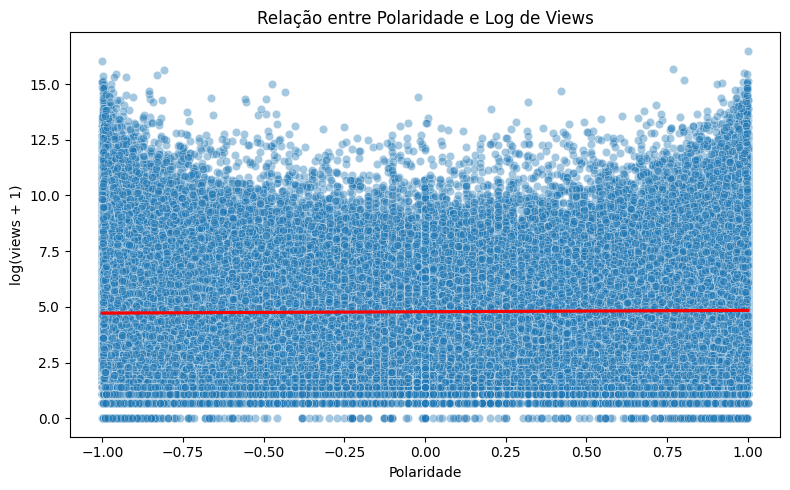

Correlação entre polaridade e views: 0.024


In [ ]:
# Relação entre polaridade e numero de views
df['log_views'] = np.log1p(df['views'])

plt.figure(figsize=(8,5))
sns.scatterplot(data=df, x='tb_polarity', y='log_views', alpha=0.4)
sns.regplot(data=df, x='tb_polarity', y='log_views', scatter=False, color='red')
plt.title("Relação entre Polaridade e Log de Views")
plt.xlabel("Polaridade")
plt.ylabel("log(views + 1)")
plt.tight_layout()
plt.show()

# Correlação numérica
corr = df[['tb_polarity', 'log_views']].corr().iloc[0,1]
print(f"Correlação entre polaridade e views: {corr:.3f}")

In [ ]:
# Modelo polinomial de segundo grau
df['tb_polarity_squared'] = df['tb_polarity'] ** 2

import statsmodels.api as sm
X = df[['tb_polarity', 'tb_polarity_squared']]
X = sm.add_constant(X)
y = df['log_views']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_views   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     881.8
Date:                Sun, 29 Jun 2025   Prob (F-statistic):               0.00
Time:                        19:07:42   Log-Likelihood:            -7.3416e+05
No. Observations:              332731   AIC:                         1.468e+06
Df Residuals:                  332728   BIC:                         1.468e+06
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   4.4153    